In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.mylib import *
from d2l import torch as d2l

In [2]:
init_Seed()

GPU ready!


In [4]:
def train(tr_set, dv_set, model, config):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_size = config['batch_size']

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)


    min_mse = 1000.
    loss_record = {'train': [], 'dev': []} 
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()    
            X, y = X.to(device), y.to(device)
            y_hat = model(X[:, 0], X[:, 1])

            mse_loss = model.cal_loss(y_hat, y)
            mse_loss.backward()
            
            optimizer.step()

            # loss_record['train'].append(mse_loss.detach().cpu().item())
            loss_record['train'].append(mse_loss.detach().cpu().item())

            # print("train_loss: {:.4f}".format(mse_loss.detach().cpu().item()))
            print("train_loss: {:.4f}".format(np.sqrt(mse_loss.detach().cpu().item())))

        scheduler.step()
        
        epoch += 1

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            early_stop_cnt = 0
            print("Saving model (epoch = {:4d}  loss = {:.4f} )".format(epoch, np.sqrt(dev_mse)))
            torch.save(model.state_dict(), config['save_path'])
        else:
            early_stop_cnt += 1
        
        loss_record['dev'].append(dev_mse)

        if early_stop_cnt > config['early_stop']:
            break

    print("Finish training after {} epochs".format(epoch))
    return min_mse, loss_record

In [5]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/           

config = {
    'n_epochs': 500,              # maximum number of epochs
    'batch_size': 5000,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.005,                # learning rate
        # 'weight_decay': 0.001
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 10,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth',  # your model will be saved here
    'D': 20
}

# **Load data and model**

In [6]:
ML100K_train = '../data/ML100K/ML100K_copy1_train.txt'
ML100K_test = '../data/ML100K/ML100K_copy1_test.txt'

ML1M_train = '../data/ML1M/ML1M_copy1_train.txt'
ML1M_test = '../data/ML1M/ML1M_copy1_test.txt'

tr_set = prep_dataloader(ML100K_train, 'train', config['batch_size'])
dv_set = prep_dataloader(ML100K_test, 'dev', config['batch_size'])
# tt_set = prep_dataloader("data/ML100K/ML100K_copy1_test.txt", 'test', config['batch_size'], target_only=target_only)

Max user: 943
Max item: 1682
Finished reading the train set of MoviesLen Dataset (60000 samples found, each dim = 2)
Max user: 943
Max item: 1679
Finished reading the dev set of MoviesLen Dataset (20000 samples found, each dim = 2)


In [7]:
model = SLMF(n_factors=config['D']).to(device)

# **Start Training!**

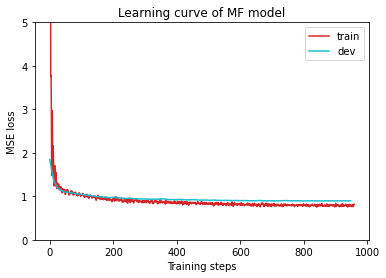

In [9]:
plot_learning_curve(model_loss_record, title='MF model')

In [10]:
np.sqrt(model_loss)

0.9459027268389076

In [11]:
np.sqrt(model_loss_record['dev'][-1])

0.9459075000997532

In [12]:
# del model
# model = MF().to(device)
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)
# # plot_pred(dv_set, model, device)  # Show prediction on the validation set
# dev(dv_set, model, device)